In [46]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from LPA import LPA
from tqdm import tqdm, trange

In [2]:
from utils import *

In [3]:
adj, adj_n, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, train_size, test_size = load_corpus('r8')

In [30]:
train_size, test_size

(5485, 2189)

In [5]:
y_train.sum()

4937.0

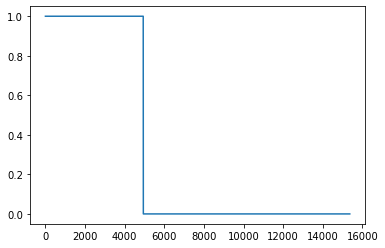

In [6]:
plt.plot(y_train.sum(axis=1))

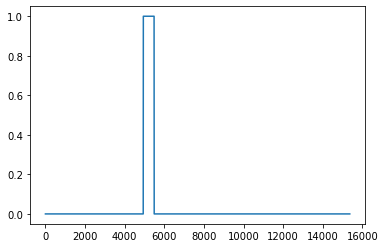

In [7]:
plt.plot(y_val.sum(axis=1))

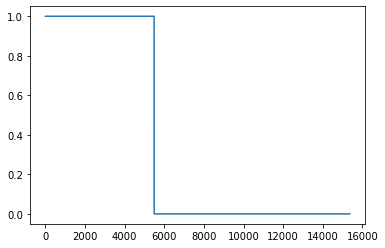

In [8]:
plt.plot((y_train + y_val).sum(axis=1))

In [10]:
vocab_size = adj.shape[0] - train_size - test_size

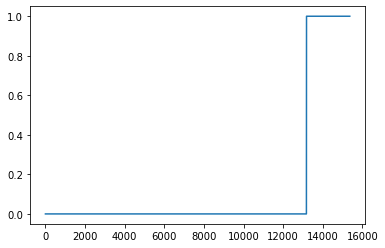

In [14]:
plt.plot(y_test.sum(axis=1))

In [19]:
type(adj)

scipy.sparse.csr.csr_matrix

In [34]:
vocab_size + train_size

13173

In [35]:
harr = np.split(adj.A, [train_size, train_size + vocab_size, train_size + vocab_size + test_size], axis=1)

In [37]:
varr = np.split(adj.A, [train_size, train_size + vocab_size, train_size + vocab_size + test_size], axis=0)

In [36]:
harr[0].shape, harr[1].shape, harr[2].shape

((15362, 5485), (15362, 7688), (15362, 2189))

In [38]:
varr[0].shape, varr[1].shape, varr[2].shape

((5485, 15362), (7688, 15362), (2189, 15362))

In [4]:
adj.shape

(15362, 15362)

In [39]:
adj2 = adj.dot(adj)

In [43]:
adj.shape

(15362, 15362)

In [50]:
adj2[:train_size, train_size:train_size+vocab_size] = adj[:train_size, train_size:train_size+vocab_size]
print('done')
adj2[train_size+vocab_size:, train_size:train_size+vocab_size] = adj[train_size+vocab_size:, train_size:train_size+vocab_size]
print('done')
adj2[train_size:train_size+vocab_size, :] = adj[train_size:train_size+vocab_size, :]

C:\Users\Shaz\anaconda3\lib\site-packages\scipy\sparse\_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


done
done


In [52]:
adj2.shape

(15362, 15362)

In [53]:
adj3 = adj2.dot(adj)

In [54]:
adj3[:train_size, train_size:train_size+vocab_size] = adj[:train_size, train_size:train_size+vocab_size]
print('done')
adj3[train_size+vocab_size:, train_size:train_size+vocab_size] = adj[train_size+vocab_size:, train_size:train_size+vocab_size]
print('done')
adj3[train_size:train_size+vocab_size, :] = adj[train_size:train_size+vocab_size, :]

done
done


In [55]:
adj3.shape

(15362, 15362)

In [56]:
with open('R8_adj_1.npy', 'wb') as f:
    np.save(f, adj)

In [57]:
with open('R8_adj_2.npy', 'wb') as f:
    np.save(f, adj2)

In [58]:
with open('R8_adj_3.npy', 'wb') as f:
    np.save(f, adj3)

In [59]:
adj4 = adj3.dot(adj)

In [60]:
adj4[:train_size, train_size:train_size+vocab_size] = adj[:train_size, train_size:train_size+vocab_size]
print('done')
adj4[train_size+vocab_size:, train_size:train_size+vocab_size] = adj[train_size+vocab_size:, train_size:train_size+vocab_size]
print('done')
adj4[train_size:train_size+vocab_size, :] = adj[train_size:train_size+vocab_size, :]

done
done


In [61]:
adj4.shape

(15362, 15362)

In [62]:
with open('R8_adj_4.npy', 'wb') as f:
    np.save(f, adj4)

In [53]:
train_size = int(y_train.sum())
val_size = int(y_val.sum())
test_size = int(y_test.sum())

In [41]:
alpha = 0.5
adj_n = adj + alpha * adj2 + alpha * alpha * adj3 + alpha * alpha * alpha * adj4

In [48]:
adj_n

<15362x15362 sparse matrix of type '<class 'numpy.float64'>'
	with 118103056 stored elements in Compressed Sparse Row format>

In [61]:
train_input = y_train
mask = 0.2

In [ ]:
def get_mask(idx, length):
    mask = np.zeros(length)
    mask[idx] = 1
    return np.array(mask, dtype=np.float64)

In [82]:
model = LPA(adj_n.todense())

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

epochs = 10

In [83]:
train_size

4937

In [84]:
y_train.shape

(15362, 8)

In [85]:
for epoch in range(epochs):
    model.train()
    print(f'\nEpoch {epoch}: ')

    train_indices = np.random.choice(list(range(train_size)), size=int(train_size * 0.8), replace=False)
    train_mask = get_mask(train_indices, len(y_train))
    train_input = y_train * train_mask[:, None]

    outputs = model(torch.tensor(train_input, dtype=torch.float64))
    loss = criterion(outputs[:train_size], torch.tensor(train_input[:train_size], dtype=torch.float))
    # train_acc = np.sum(torch.argmax(outputs, dim=1) == train_target)

    preds = torch.argmax(outputs, dim=1)
    train_acc = torch.eq(preds[:train_size], torch.tensor(np.argmax(y_train, axis=1)[:train_size])).sum() / train_size
    print(f'Training Loss: {loss}\tTraining Accuracy: {train_acc}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    preds = model(torch.tensor(y_train, dtype=torch.float64))
    loss = criterion(preds[train_size: train_size+val_size], torch.tensor(y_val[train_size: train_size+val_size]))
    preds = torch.argmax(preds, dim=1)
    val_acc = torch.eq(preds[train_size: train_size+val_size], torch.tensor(np.argmax(y_val, axis=1)[train_size: train_size+val_size])).sum() / val_size
    print(f'Validation Loss: {loss}\tValidation Accuracy: {val_acc}')


Epoch 0: 
Training Loss: 1.66330051612187	Training Accuracy: 0.045169129967689514
Validation Loss: 2.0794415416798357	Validation Accuracy: 0.051094889640808105

Epoch 1: 
Training Loss: 1.1497307282318783	Training Accuracy: 0.8079805374145508
Validation Loss: 2.0794415416798357	Validation Accuracy: 0.051094889640808105

Epoch 2: 
Training Loss: 1.0425484633735584	Training Accuracy: 0.9635406136512756
Validation Loss: 2.0794415416798357	Validation Accuracy: 0.051094889640808105

Epoch 3: 
Training Loss: 1.0250937799681523	Training Accuracy: 0.991290271282196
Validation Loss: 2.0794415416798357	Validation Accuracy: 0.051094889640808105

Epoch 4: 
Training Loss: 1.0198689677757986	Training Accuracy: 0.9987846612930298
Validation Loss: 2.0794415416798357	Validation Accuracy: 0.051094889640808105

Epoch 5: 
Training Loss: 1.0192154305246526	Training Accuracy: 0.9997974634170532


KeyboardInterrupt: 